In [0]:
# import packages
import sys
import numpy as np
import time
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd

### **Description**: 

Connect 4 is a two-player connection game. One player is X and the other is O. The player first choose a column and then take turns dropping one symbol from the top into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. 

For this project, I apply minimax algorithm , alpha-beta-pruning (abPrune), and iterative deepening DFS (iter_DFS). Minimax algorithm with big depth can be very costly, so abPrune helps cut the search space, whereas iter_DFS helps search the game tree faster. 

I conduct 2 use cases: one is having AI depth 10 playing with AI depth 5 (depth 10 wins). Another is having a human player playing against an AI, with selection for difficulty (~ tree depth from 1-10).  

**LOs Application**:
- **#aicoding**: I program a two-player game with an ai component. Apply the concepts from this class: minimax, alpha-beta pruning, iterative DFS to reduce the search space and running time. All functions are well commented on and function properly.
- **#search**: Apply the alpha-beta pruning and iterative DFS to reduce the space and running time traversing the game tree, which is exponentially more significant by each depth.

**HC Applications**:
- **#heuristics**: The depth of the search tree for Connect 4 can be up to 42, which will create an exponentially large number of nodes. Hence, I apply heuristics to develop a temporary evaluation for each state and use if for the depth-5 program to cut the time. I apply #heuristics properly for CS context by selecting the appropriate heuristics to optimize our outcome.
- **#utility**: In the situation of games: #utility means maximizing our benefits while mitigating others: which perfectly describes the minimax algorithm. Assuming the opponent will minimize our scores. I apply #utility properly for the CS context to program the minimax algorithms to calculate ten steps ahead on which node will optimize our outcome. 



**Basic function**: Check the validity, query all the possible combinations, checking winning state

In [0]:
# For conenct 4, it's more beneficial to start from the middle: set the order
order=[3,2,4,1,5,0,6]

# search for all available moves
def available_move(state):
  available_moves = []
  # search though each column
  for x in order:
    # scan through the row
    for y in range(size_y-1, -1, -1):
      # if empty tile: accet and move on to mext column
      if state[y][x] == 0:
        available_moves.append([y,x])
        break
  return available_moves

# check the move input by users is valid: 
def check_move(state, x, auto = -1):
  # must be a number between 0 and 8: 1-7
  while not (x.isnumeric() == True and int(x) > 0 and int(x) < 8):
    print ("Invalid move!")
    x = input('n: ')
  #check the possible moves
  cols, rows = (np.array(available_move(state)).T).tolist()
  x = int(x)-1
  
  # if not in the set of available moves
  while x not in rows:
    print ("Invalid move!")
    x = input('n: ')
  # change the state
  state[cols[rows.index(x)]][x] = auto

# check if the move is valid in the game board
def check_constraint(y, x):
  if (y < 0) or (y > size_y-1) or (x < 0) or (x > size_x - 1):
    return False
  return True 

In [0]:
# Use to draw the table:
def draw(state):

  # the  fisrt column
  for i in range(size_x):
    sys.stdout.write(" %d " % (i+1))

  print ("")
  print ("_" * (size_x * 3))

  # print every value, separate by ||
  # 1-> X, -1 -> O, 0 -> -
  for i in range(size_y):
    for j in range(size_x):
      if state[i][j] == 1:
        sys.stdout.write("|O|")
      elif state[i][j] == -1:
        sys.stdout.write("|X|")
      else:
        sys.stdout.write("|-|")
    print ("")
  print ("_" * (size_x * 3))
  print ("")

In [0]:
# check if the game is over or not:
def win(state):
  # winning scenario
  ai_win = [1,1,1,1]
  human_win = [-1,-1,-1,-1]

  # search for all lines (horizontal, vertical, diagonal) - explained below
  lines = all_lines(state)

  #search in the lines
  for line in lines:
    # less than 4 line are useless
    if len(line) < 4:
      continue
    # if ai_win move is in 1 line in the state: ai win
    if sub_list(ai_win, line):
      return 1
      break
    # if human_win move is in 1 line: human win
    if sub_list(human_win, line):
      return -1
      break
  # no one win yet
  return 0

# search for all the lines in the matrix
def all_lines(state):
  # initialize
  lines = []
  
  # horizontal
  for y in range(size_y):
    lines.append(state[y])
  
  # vertical
  for x in range(size_x):
    lines.append([state[i][x] for i in range(size_y)])

  #all diagonal:
  # https://stackoverflow.com/questions/6313308/get-all-the-diagonals-in-a-matrix-list-of-lists-in-python
  state_array = np.array(state)
  # get diagonal line from left to right
  diags = [state_array[::-1,:].diagonal(i) for i in range(-state_array.shape[0]+1,state_array.shape[1])]
  # get diagonal line from right to left
  diags.extend(state_array.diagonal(i) for i in range(state_array.shape[1]-1,-state_array.shape[0],-1)) 
  # add all the line into the whole lines
  lines += [n.tolist() for n in diags]

  return lines

# check if list1 is a sublist of list2: use to check winning stage
def sub_list(list1, list2):
  l1 = len(list1)
  l2 = len(list2)
  #iterate through list2 to find list1
  for i in range(l2 - l1 + 1):
    if list1 == list2[i:i+l1]:
      return True

**Dummy version**: Assign weights to a small set of possible moves. This version performs poorly. We will use a more extensive weight in the next part. This one is to give a general understanding of the approach: each 4-line configuration has a specific weight. [1,1,1,1] will have the highest weight, whereas [-1,-1,-1,-1] will have the most negative weight. We extend to all 4, 5, 6, 7 line.

In [0]:
# search through different axis: x-axis, y-axis, and 2 diagonal axis. Each axis has 2 direction to move
directions = [[[1, 0], [-1, 0]],
              [[0, 1], [0, -1]],
              [[1, 1], [-1, -1]],
              [[1, -1], [-1, 1]]]

# evaluation for a state configuration is the sum of all configuration
def evaluate_location(state, y, x, player, opponent):
  score = 0
  # for each axis
  for axis in directions:
    # checking what if we play at that spot and what if the opponent play at hat spot
    cur_line = [player]
    opp_line = [opponent]

    # moving direction
    direction1, direction2 = axis
    y_dir = direction1[0]
    x_dir = direction1[1]
    # max line is 4, but we have 1 component already -> check 3
    for i in range(3):
      # moving size
      step = i+1
      # new moves 
      y_new = step*y_dir + y
      x_new = step*x_dir + x

      # if does not violate the constraint: add to line
      if check_constraint(y_new, x_new) == False:
        break
      cur_line += [state[y_new][x_new]]
      opp_line += [state[y_new][x_new]]

    # moving in the other direction
    y_dir = direction2[0]
    x_dir = direction2[1]
    # max line is 4, but we have 1 component already -> check 3
    for i in range(3):
      # moving size
      step = i+1
      # new moves
      y_new = step*y_dir + y
      x_new = step*x_dir + x

      # if does not violate the constraint: add to line: but add in the opposite direction
      if check_constraint(y_new, x_new) == False:
        break
      cur_line = [state[y_new][x_new]] + cur_line
      opp_line = [state[y_new][x_new]] + opp_line

    # if length < 4: no need to care
    if len(cur_line) >= 4:
      for i in range(len(ai_strat)):
        # check in the score table
        if sub_list(ai_strat[i], cur_line):
          score += ai_strat_score[i]
      
      # this is for blocking startegy: if we don't play at [i, j] and the opponent playes, what will happen
      for i in range(len(block_strat)):
        if sub_list(block_strat[i], opp_line):
          score += block_strat_score[i]
  
  # result
  return score

# a state evaluation = sum of all the coordinates
def eval(state):
  player = 1
  opponent = -1
  winner = win(state)

  # if win, assign biggest value
  if winner == player:
    return np.inf
  # lose -> assign the worst 
  elif winner == opponent:
    return -np.inf

  # start calculating score
  score = 0 
  for x in range(size_x):
    for y in range(size_y):
      if state[y][x] == 0:
        score += evaluate_location(state, y, x, player, opponent)

  return score

# snap shot or score table
ai_strat = [[1,1,1,1], 
            [0,1,1,1],[1,1,1,0],
            [1,1,0,0],[1,0,0,1],[0,1,1,0],[0,0,1,1],[1,0,1,0],[0,1,0,1],
            [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
ai_strat_score = [100, 
                  30, 30, 
                  10,10,10,10,10,10, 
                  2,2,2,2]

block_strat = (np.array(ai_strat)*-1).tolist()
block_strat_score = (np.array(ai_strat_score)*-1).tolist()

In [0]:
#moves in slot x acording to valid moves function
def set_state(state, x, player):
  val = available_move(state)
  state[val[x][0]][val[x][1]] = player

**Minimax + AB Pruning**

In [0]:
#Alpha Beta Pruning Search Algorithm
def abPrune(state, depth = 4):
  
  # find the minimum (left side of the tree): the opponent's move to make us worst
  def abMin(state, depth, alpha, beta):
    # query all the available states
    available_moves= available_move(state)

    # of no more moves or ran out of states
    if (depth==0 or not available_moves):
      # return the score
      return eval(state)

    # check our opponents' best move
    cur_val = +1000000
    for y,x in available_moves:
      # assign values
      state[y][x]= -1
      cur_val = min(cur_val, abMax(state, depth-1, alpha, beta))
      # replacing back in the grid
      state[y][x] = 0

      # always look for the worst option
      if cur_val <= alpha: 
        return cur_val
      # returning the worst option for us
      beta = min(beta, cur_val)
    return cur_val
  
  # find the maximum (right side): our move to make us best
  def abMax(state, depth, alpha, beta):
    # all the avaliable states
    available_moves = available_move(state)

    # if no more depth or ran out of states
    if (depth==0 or not available_moves):
      # scoring
      return eval(state)

    # check our best move
    cur_val = -1000000
    for y,x in available_moves:
      # our move
      state[y][x] = 1
      # returning our best moves
      cur_val = max(cur_val, abMin(state, depth-1, alpha, beta))
      # assigning back
      state[y][x] = 0
      # always look for the best
      if cur_val >= beta:
        return cur_val
      # the best options
      alpha = max(alpha, cur_val)
    return cur_val
    
  # complete ab pruning process
  def ab(state, depth, alpha, beta):
    tracking = []
    cur_val = -1000000

    for y,x in available_move(state):
      # assigning value and iterate
      state[y][x] = 1

      # best move
      cur_val = max(cur_val, abMin(state, depth-1, alpha, beta))
      tracking.append(cur_val)
      
      state[y][x] = 0

    # optimize
    largest = max(tracking)
    idx = tracking.index(largest)

    # get the index and result of best outcome
    return [idx, largest]

  return ab(state, depth, -1000000, +1000000)

In [0]:
import time
#Iterative Deepening DFS #https://www.geeksforgeeks.org/iterative-deepening-searchids-iterative-deepening-depth-first-searchiddfs/
def iter_DFS(state, max_depth = 10):
  global order

  # starting depth
  depth = 1
  # abPrune: start pruning
  result = abPrune(state, depth)
  
  # keep moving until depth > max_depth (random number)
  time_start = time.time()
  while True:
    # start timer
    

    # terminal score
    if abs(result[1]) > 5000:
      return result[0]
    
    # get results
    temp = result[0]

    #chaning the order in considering moves
    while temp != 0:
      order[temp-1], order[temp] = order[temp], order[temp-1]
      temp -= 1

    # adding depth
    depth += 1
    # prune again
    result = abPrune(state, depth)

    # end timer
    time_end = time.time()

    # if exceed max depth
    if depth >= max_depth:
      return result[0]

    # we don;t want the ai to run so long, so we output after 10s
    if time.time() - time_start > 10:
      print("I stressed my brain out! You're good! Here's my move:")
      return result[0]

**Weight matrix**

This is the weight matrix for all possible combination of 4, 5, 6, 7 lines. The weight is retrived from (Saveski, 2018)

In [0]:
weight_4 = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vS03jXNPKCZqb5aWBnocQSaIR2KO5sh5KCyeDZDHsjl5947g3Mh9DHNqJ3EnW25zLvpDfk4qma6XLu_/pub?gid=618726834&single=true&output=csv")
weight_5 = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vS03jXNPKCZqb5aWBnocQSaIR2KO5sh5KCyeDZDHsjl5947g3Mh9DHNqJ3EnW25zLvpDfk4qma6XLu_/pub?gid=13430066&single=true&output=csv")
weight_6 = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vS03jXNPKCZqb5aWBnocQSaIR2KO5sh5KCyeDZDHsjl5947g3Mh9DHNqJ3EnW25zLvpDfk4qma6XLu_/pub?gid=0&single=true&output=csv")
weight_7 = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vS03jXNPKCZqb5aWBnocQSaIR2KO5sh5KCyeDZDHsjl5947g3Mh9DHNqJ3EnW25zLvpDfk4qma6XLu_/pub?gid=2101610978&single=true&output=csv")

In [0]:
# all the data
data = [weight_4, weight_5, weight_6, weight_7]
length = [4, 5, 6, 7]

# initialize the storage 
store4 = {}
store5 = {}
store6 = {}
store7 = {}
storage = [store4, store5, store6, store7]

# convert the data and add all the score to a dictionary
# this part is only preprocessing the data
for i in range(len(data)):
  datum = data[i]
  store = storage[i]
  value = []
  for k in range(len(datum)):
    transform_value = ("%0" + str(length[i]) + "d") % datum["value"][k]
    hash_val = str(transform_value).replace("2", "-1")
    store[hash_val] = datum["weight"][k]

In [0]:
# real evaluation method: using all the weights
def eval(state):
  global length
  global storage
  score = 0

  # get all the possible lines
  lines = all_lines(state)

  # score = sum of all the lines in the matrix
  for line in lines:
    # length < 4: no need to care cause 4 lines is a must to win
    if len(line) < 4:
      continue
    
    # get the appropriate storage
    cur_idx = length.index(len(line))
    store = storage[cur_idx]
    # get the hash_val to query from the dictionary
    hash_val = ''.join(str(e) for e in line)

    # all score
    score += store[hash_val]
  return score

### **Game**

The first cell is an AI vs AI: my algorithm with depth = 10 vs one with depth = 5. The one with depth 10 wins over the one with depth 5.

Next cell is for player to play. I lost to my depth 5 ai player.

**Part 1: AI vs AI**: depth 10 vs depth 5

In [12]:
# total score
size_y = 6
size_x = 7
depth = 5

state = [[0 for _ in range(size_x)] for __ in range(size_y)]
 

# while still slot to fill
move = 0
while available_move(state):
  # even move
  if move%2 == 0:
    move += 1
    print("Move number {}: AI #1's turn".format(move))
    # set a timer
    start_time = time.time()
    if move != 1:
      print("AI #1: Nice move! I'll have to think for a bit!")
    # iterate through the game tree
    set_state(state, iter_DFS(state, 10), 1)
    draw(state)
    print("After ", round(time.time() - start_time) + 1, " seconds thinking!")

  # odd move
  else:
    move += 1
    print("Move number {}: AI #2's turn".format(move))
    start_time = time.time()
    print("AI #2: Good job! My turn to think :)")
    # iterate through the game tree
    set_state(state, iter_DFS(state, 5), -1)
    draw(state)
    print("After ", round(time.time() - start_time) + 1, " seconds thinking!")

  # winning result
  if win(state) == -1:
    print("AI #2 is the winnerrrr!!!!")
    print("AI #2: I wins hahaha!")
    draw(state)
    break

  
  if win(state) == 1:
    print("AI #1 is the winnerrrr!!!!")
    print("AI #1: I am better than you!!! :)")
    break

Move number 1: AI #1's turn
I stressed my brain out! You're good! Here's my move:
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||O||-||-||-|
_____________________

After  11  seconds thinking!
Move number 2: AI #2's turn
AI #2: Good job! My turn to think :)
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||X||O||-||-||-|
_____________________

After  1  seconds thinking!
Move number 3: AI #1's turn
AI #1: Nice move! I'll have to think for a bit!
I stressed my brain out! You're good! Here's my move:
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||O||-||-||-||-|
|-||-||X||O||-||-||-|
_____________________

After  28  seconds thinking!
Move number 4: AI #2's turn
AI #2: Good 

**Part 2: AI vs AI**: Analysis between pairwaise matches from depth 1 to 7

In [0]:
# total score
size_y = 6
size_x = 7
depth = 5


 
def play(depth1, depth2):
  time1 = []
  time2 = []
  state = [[0 for _ in range(size_x)] for __ in range(size_y)]
  # while still slot to fill
  move = 0
  while available_move(state):
    # even move
    if move%2 == 0:
      move += 1
      # set a timer
      start_time = time.time()
      # iterate through the game tree
      set_state(state, iter_DFS(state, depth1), 1)
      time1.append(time.time() - start_time)

    # odd move
    else:
      move += 1
      
      start_time = time.time()
      # iterate through the game tree
      set_state(state, iter_DFS(state, depth2), -1)
      time2.append(time.time() - start_time)

    # winning result
    if win(state) == -1:
      result = -1
      return result, np.mean(time1), np.mean(time2)
      break

    
    if win(state) == 1:
      result = 1
      return result, np.mean(time1), np.mean(time2)
      break
  return 0, np.mean(time1), np.mean(time2)

In [0]:
# result_record[i]: result i play against other: 1 if i win, -1 if i lose, 0 if draw
N = 7
result_record = [[] for _ in range(N)]
present_result_record = [[] for _ in range(N)]

# time_home_record[i][j]: time i cost when i vs j 
time_home_record = [[] for _ in range(N)]
present_time_home_record = [[] for _ in range(N)]

# time_away_record[i][j]: time j cost when i vs j 
time_away_record = [[] for _ in range(N)]
present_time_away_record = [[] for _ in range(N)]

for depth1 in range(N):
  for depth2 in range(N):
    #print(depth1, depth2)
    result, time1, time2 = play(depth1 + 1, depth2 + 1)
    result_record[depth1].append(result)
    time_home_record[depth1].append(time1)
    time_away_record[depth1].append(time2)

for i in range(N):
  present_result_record[i] = ["Depth " + str(i+1)] + result_record[i]
  present_time_home_record[i] = ["Depth " + str(i+1)] + time_home_record[i]
  present_time_away_record[i] = ["Depth " + str(i+1)] + time_away_record[i]

In [15]:
print(tabulate(present_result_record, headers= ["Depth " + str(i+1) for i in range(N)]))

           Depth 1    Depth 2    Depth 3    Depth 4    Depth 5    Depth 6    Depth 7
-------  ---------  ---------  ---------  ---------  ---------  ---------  ---------
Depth 1          1          1          1         -1         -1          1          0
Depth 2          1          1          1         -1         -1          1          0
Depth 3          1          1          1          1          1          1          1
Depth 4          1          1          1         -1          1          1          1
Depth 5          1          1         -1          1          1          1          1
Depth 6         -1         -1         -1         -1         -1          1         -1
Depth 7          1          1          1          1          1         -1          1


In [16]:
print(tabulate(present_time_home_record, headers= ["Depth " + str(i+1) for i in range(N)]))

            Depth 1     Depth 2     Depth 3     Depth 4     Depth 5     Depth 6     Depth 7
-------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Depth 1  0.00397251  0.00359475  0.00398839  0.00393493  0.00335439  0.00424588  0.00337117
Depth 2  0.00390619  0.00402462  0.00393882  0.00392917  0.00332775  0.00422464  0.0032877
Depth 3  0.0155327   0.0156759   0.013945    0.0157022   0.0149929   0.0158774   0.0169935
Depth 4  0.059597    0.058298    0.0595243   0.0463924   0.0639935   0.0602978   0.0529915
Depth 5  0.25146     0.253011    0.161102    0.203386    0.16943     0.265315    0.174722
Depth 6  0.586758    0.629097    0.609956    0.632597    0.607308    0.741331    0.845137
Depth 7  2.46071     2.54834     2.75253     2.12555     1.77397     2.14283     1.65966


In [17]:
print(tabulate(present_time_away_record, headers= ["Depth " + str(i+1) for i in range(N)]))

            Depth 1     Depth 2     Depth 3    Depth 4    Depth 5    Depth 6    Depth 7
-------  ----------  ----------  ----------  ---------  ---------  ---------  ---------
Depth 1  0.00405841  0.00352865  0.0138756   0.0423746   0.155805   0.841318    2.22451
Depth 2  0.00397658  0.00407711  0.0131456   0.0440853   0.155739   0.838967    2.21726
Depth 3  0.00445428  0.00454807  0.013797    0.0496254   0.160098   0.654848    2.3252
Depth 4  0.00396058  0.00386056  0.0128266   0.043655    0.184953   0.658056    1.20109
Depth 5  0.00390611  0.00390339  0.0107121   0.0607644   0.185251   0.964602    2.40417
Depth 6  0.00287534  0.00287617  0.00960918  0.0409449   0.128311   0.64728     2.45096
Depth 7  0.00377699  0.00381105  0.0169116   0.0653051   0.155627   0.558808    1.96797


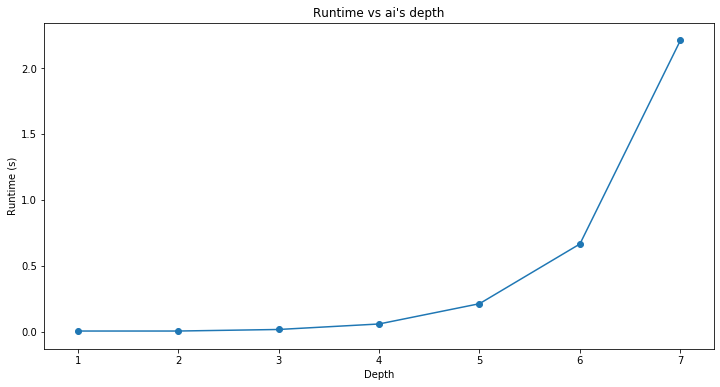

In [18]:
plt.figure(figsize= (12,6))
plt.plot(range(1, N+1), np.mean(np.array(time_home_record), axis = 1))
plt.scatter(range(1, N+1), np.mean(np.array(time_home_record), axis = 1))
plt.xlabel("Depth")
plt.ylabel("Runtime (s)")
plt.title("Runtime vs ai's depth")
plt.show()

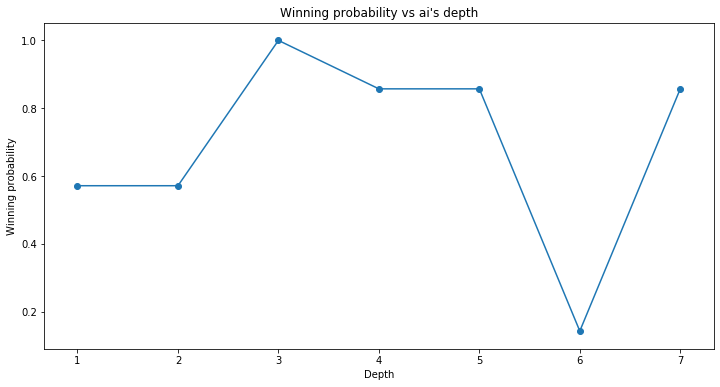

In [19]:
plt.figure(figsize= (12,6))
plt.plot(range(1, N+1), np.mean(np.array(result_record) == 1, axis = 1))
plt.scatter(range(1, N+1), np.mean(np.array(result_record) == 1, axis = 1))
plt.xlabel("Depth")
plt.ylabel("Winning probability")
plt.title("Winning probability vs ai's depth")
plt.show()

**Part 3**: Human vs AI

In [20]:
# total score
size_y = 6
size_x = 7
depth = 5

depth = input("WELCOME TO CONNECT 4! Please select the difficulty (1-10): ")
while depth.isnumeric() == False or int(depth) < 0 or int(depth) > 10:
  print("INVALID DIFIICULTY: must be integer from 1 to 10.")
  depth = input("WELCOME TO CONNECT 4! Please select the difficulty (1-10): ")

depth = int(depth)
print("You are X, the other player will be O")
# initialize the state
state = [[0 for _ in range(size_x)] for __ in range(size_y)]
human_first = input("Do you want to play first? (Y/N)?")
#the player plays first

move = 0
if human_first.capitalize() == 'Y':
  # present table;
  draw(state)    

  # while still slot to fill
  while available_move(state):
    n = input("Your move: (1-7) ")
    check_move(state, n)
    draw(state)

    # if user win: 
    if win(state) == -1:
      print("You win!!! Congrats!")
      draw(state)
      break

    start_time = time.time()
    print("Nice move! I'll have to think for a bit!")
    set_state(state, iter_DFS(state, depth), 1)
    draw(state)
    print("After ", round(time.time() - start_time), " seconds thinking!")
    if win(state) == 1:
      print("AI wins! Better luck next time :)")
      break
        
#The AI ai_score plays first
else:
  while available_move(state):
    start_time = time.time()
    print("Nice move! I'll have to think for a bit!")
    set_state(state, iter_DFS(state, depth), 1)
    draw(state)
    print("After ", round(time.time() - start_time) + 1, " seconds thinking!")
    if win(state)==1:
      print("AI wins! Better luck next time :)")
      break

    n = input("Your move: (1-7) ")
    check_move(state, n)
    draw(state)
    if win(state) == -1:
      print("You win!!! Congrats!")
      break

WELCOME TO CONNECT 4! Please select the difficulty (1-10): 7
You are X, the other player will be O
Do you want to play first? (Y/N)?y
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
_____________________

Your move: (1-7) 4
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||X||-||-||-|
_____________________

Nice move! I'll have to think for a bit!
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||O||X||-||-||-|
_____________________

After  5  seconds thinking!
Your move: (1-7) 4
 1  2  3  4  5  6  7 
_____________________
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||-||-||-||-|
|-||-||-||X||-||-||-|
|-||-||O

### Reference: 

Saveski, M. (n.d.). AI Agent. Retrieved December 17, 2019, from http://web.media.mit.edu/~msaveski/projects/.